# Simulating the paired birth death process
Tim Tyree<br>
10.12.2022

## import python modules

In [1]:
from lib import *

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %reload_ext autoreload

In [4]:
from collections import deque
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

In [5]:
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# # %matplotlib notebook
# %matplotlib inline

In [6]:
wjr=recall_powerlaw_fits_to_full_models()

# define module

In [72]:
#TODO: move these to lib
#set initial number of particles
@njit
def comp_first_passage_time_paired_bd_process(
        N=6,
        DT=0.1,
        random_state=42,
        max_num_steps=1000000,**kwargs):
    """
    Example Usage:
first_passage_time = comp_first_passage_time_paired_bd_process(N=6,
            random_state=42,max_num_steps=1000000)#,**kwargs)
    """
    np.random.seed(random_state)
    error_code=0
    assert N%2==0
    step=0
    dont_break=True
    while dont_break:
        #compute transition probabilities
        pup = Wp(N)*DT
        pum = Wm(N)*DT
        #randomly sample a value
        p = np.random.rand()
        #change depending on that value
        if p>pup:
            N+=2
        if p<pum:
            N-=2
        #i know edge case exists for ~1/2 of the sample in theory.
        #decide edge cases by predominance
        #by setting switch to go up instead of down when transition is otherwise undefined.
        #else, we'll keep to the default, wherein negative wins...
        if pum>pup:
            #closest one to half wins
            dpum=np.abs(0.5-pum)
            dpup=np.abs(0.5-pup)
            if dpup<dpum:
                #then for once, positive wins!
                if (p>pup) & (p<pum):
                    N+=2
        #break if not a particle exists
        if N<1:
            dont_break=False
        elif step>max_num_steps:
            dont_break=False
            error_code=1
        step+=1

    first_passage_time = step*DT
    return first_passage_time

def construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=200,**kwargs):
    """
    Example Usage:
DT=0.000025 #stable?
t_matrix = construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=200)#,**kwargs)
t_matrix*=DT #transfer func is now in dimensionless units 
    """
    dim=max_num_particles_init_over_2
    #precompute the transition matrix
    N_values = 2*(1+np.arange(dim))
    t_matrix=np.zeros((dim,dim))
    for i,N in enumerate(N_values):
        flux_in_lo = Wp(N-2)
        flux_in_hi = Wm(N+2)
        flux_out= Wp(N) + Wm(N)
        t_matrix[i,i]-=flux_out
        t_matrix[i,i-1]+=flux_in_lo
        if i+1<dim:
            t_matrix[i,i+1]+=flux_in_hi
    t_matrix[0,0] = -(Wm(2)+Wp(2)) # from N=2
    t_matrix[0,1] = Wm(4) # from N=4
    #reflecting bc at end
    Nmax=int(N_values[-1])
    t_matrix[-1,-1] = -Wm(Nmax) #-(Wm(Nmax)+Wp(Nmax)) 
    t_matrix[-1,-2] = Wp(Nmax-2) 
    return t_matrix

def integrate_transition_matrix(t_matrix,P_values,
                                num_steps=100000,
                                save_every=1000,**kwargs):
    """
    Example Usage:
P_values=P_qs.copy()
print(f"{sum(P_values)=}")
t_values,P_net_values = integrate_transition_matrix(t_matrix,P_values,
                                num_steps=100000,save_every=1000)#,**kwargs)
print(f"{P_net_values[-1]=}")
    """
    #input:  
    #output: 
    P_net_lst=[]
    step_lst=[]
    for step in range(num_steps):
        # dP_values=np.dot(t_matrix,P_values)
        P_values+=np.dot(t_matrix,P_values)#dP_values
        if step%save_every==0:
            P_net = np.sum(P_values)
            #record
            P_net_lst.append(P_net)
            step_lst.append(step)
        #P_net_values[step]=P_net
    P_net_values=np.array(P_net_lst)
    t_values=np.array(step_lst)*DT #seconds
    return t_values,P_net_values


# t_values=np.arange(num_steps)*DT #seconds

# scratchwerk

In [75]:
# #define token system parameters
# num=4/3
# nup=2/3
# A=1.
# Mp=1.
# # mag_ratio=0.5 #minus divided by plus
# # Mm=float(Mp * mag_ratio)
# Mm=0.5
# comp_Wp = get_comp_W(A,nup,Mp)
# comp_Wm = get_comp_W(A,num,Mm)
# Wp = njit(comp_Wp)
# Wm = njit(comp_Wm)


In [76]:
# #define time step, DT
# DT = 0.1
# # DT = 0.025
# print(f"let {DT=} seconds.")
# print(f"{np.sqrt((DT*512)**2*100)=}")
# print(f"{np.log(128)/np.log(2)=}")
# print(f"{np.sqrt(128/2)=}")

__result:__ ^that attempt is inefficient.  it didn't even finish after 10000002 time steps


In [9]:
#compute the probability of upward/downward transition by powerlaw
#input: N, Wp, Wm
#output: real value between 0 and 1
#TODO: implement linked list bc it handles infinite spaces well.
#HINT: stackoverflow numpy linked list datatype

In [11]:
# #test comp_first_passage_time_paired_bd_process works
# random_state=42
# np.random.seed(random_state)

# max_num_steps=100000



# # first_passage_time = comp_first_passage_time_paired_bd_process(N=6,DT=DT,
# #                                             max_num_steps=1000000)
# comp_first_passage_time_paired_bd_process(
#         N=6,
#         DT=0.1,
#         random_state=43,
#         max_num_steps=1000000)

# # first_passage_time
# #TODO: vectorize ^this
# # first_passage_time = comp_first_passage_time_paired_bd_process(N=6,
# #             random_state=42,max_num_steps=1000000)#,**kwargs)
# # first_passage_time


In [12]:
#warning >5 min run time
# #simulate first passage times many times
# max_num_steps=1000000
# num_epochs=100
# DT=0.01
# seed=random_state
# N_values  = np.arange(2,80,2)
# zeroes_values = np.zeros_like(N_values)
# first_passage_time_values_lst = []
# for epoch in range(num_epochs):
#     first_passage_time_values = zeroes_values.copy()    
#     for i,N in enumerate(N_values):
#         first_passage_time_values[i]=comp_first_passage_time_paired_bd_process(
#                 N=N,DT=DT,random_state=seed*(epoch+1),max_num_steps=max_num_steps)
#     #record
#     first_passage_time_values_lst.append(first_passage_time_values.copy())
# #     first_passage_time_values_lst.append(first_passage_time_values)

In [13]:
# first_passage_time_values_lst[1]

In [14]:
# arr = np.stack(first_passage_time_values_lst)
# y_values = np.mean(arr,axis=0)
# plt.plot(N_values,y_values)

In [15]:
# #DONE: estimate the distribution of termination times
# arr[-1].shape

In [16]:
# arr[:,-1]

In [17]:
# fontsize=14
# bins=np.arange(4,20,0.2)
# fig,ax=plt.subplots()
# for i in range(10):
#     ax.hist(arr[:,i],bins=bins,label=i)
# format_plot(ax=ax,xlabel='x',ylabel='y',fontsize=fontsize)
# ax.legend(fontsize=fontsize,loc='upper right')
# plt.show()

In [18]:
# TODO: average ^this over the expected number of particles from the qs distrib

In [19]:
# def comp_probability_current(N,N_values,P_values,Wp,Wm):
#     """returns the probability current in the paired birth-death process.
    
#     N_values is int array indexed by int N.  
#     P_values is a float array. 
#     Wp,Wm are real functions that return floats.
    
#     Example Usage:
# P_values=np.ones(N_values.shape[0])
# flux_in_hi , flux_in_lo , flux_out = comp_probability_current(N,N_values,P_values,Wp,Wm)
#     """
#     P = float(P_values[N==N_values])
#     Pp= float(P_values[N+2==N_values])
#     Pm= float(P_values[N-2==N_values])
#     flux_in_lo = Wp(N-2)*Pm 
#     flux_in_hi = Wm(N+2)*Pp 
#     flux_out= Wp(N)*P    + Wm(N)*P 
#     current = flux_in_hi + flux_in_lo - flux_out
#     return flux_in_hi , flux_in_lo , flux_out
#     #return current

# integrate the transition matrix

In [77]:
#DONE: dev deterministic one step method from the recurrance relation from the master equation
#input: Wp, Wm
#output: t_matrix = transition matrix for this linear system of ode's
#input: t_matrix,p_values
#output: number of steps until termination

In [78]:
max_num_particles_init_over_2=512
max_num_particles_init_over_2=50
max_num_particles_init_over_2=200


In [79]:
# input_fn = search_for_file()
# input_fn

kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [151]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'

In [152]:
#TODO: compute the eigenvalues of the transition matrix
#TODO: compute the fraction terminated time trace initializing at the quasistatic distribution
#estimate the quasistatic distribution
# L=5 #cm
# A=L**2
A = 100
num_iter=20

#TODO: recall the powerlaw fits to the FK model 
#heretim

# Wp = get_comp_W(A,nup,Mp)
# Wm = get_comp_W(A,num,Mm)
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
Wp = njit(comp_Wp)
Wm = njit(comp_Wm)

# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=num_iter,freq_prev=100.)

In [153]:
# DT=0.01
# DT=0.0025
# DT=0.0000025 #stable at N=Nmax measurement as initial condition
#DONT: #transpose
# t_matrix = t_matrix.T.copy()
# num_steps=100000
# save_every=1000
# num_steps=int(1e8)
# save_every=10000
# num_steps=int(1e6)  #gives a perfect exponential curve in <60 seconds
#TODO: use  ^this 1e6 time steps to deduce the 
# functional dependence / gradients of nup,num,Mp,Mm evaluated at the full models
#implement the absorbing boundary condition at N=0
#DONE: do a basic numerical test case using an initial state measured to be at N=2.
# P_values = np.zeros(dim)
# P_values[0]=1. #measured to be at N=2.
# P_values[-1]=1. #measured to be at N=Nmax.

In [154]:
DT=0.000025 #stable
t_matrix = construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=200)#,**kwargs)
t_matrix*=DT #transfer func is now in dimensionless units 

In [155]:
# num_iter=int(Nmax/2)
N_qs,P_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=dim,freq_prev=1.)
# P_qs/=np.sum(P_qs) #normalize for 1.0000000000000002 floating point arith error
# assert np.sum(P_qs)==1
P_qs.shape,np.sum(P_qs)

((200,), 0.9999999999999999)

In [156]:
#num_steps=100000
# tmax=2.5
tmax=25
num_steps=int(tmax/DT)
P_values=P_qs.copy()
print(f"{sum(P_values)=}")
t_values,P_net_values = integrate_transition_matrix(t_matrix,P_values,
                                num_steps=num_steps,save_every=1000)#,**kwargs)
print(f"{P_net_values[-1]=}")


sum(P_values)=1.0000000000000002
P_net_values[-1]=0.5762150896518867


In [157]:
#heretimheretim
#DONE: find where I directly integrate the mastser equations
#DONE: wrap it to foo
#DONE: test it where it is
#TODO: call that function here to test Eqn. 10

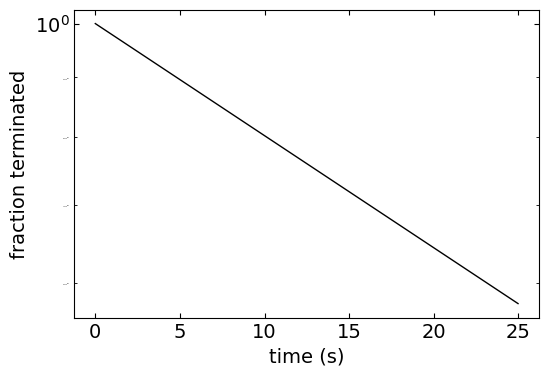

In [158]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(t_values,P_net_values,lw=1,color='k')
# ax.plot(t_values,P_net_values,lw=1)
# ax.set_xlim([DT/2,1.1])
# ax.set_ylim([0.001,1])
# ax.set_xscale('log')
ax.set_yscale('log')
format_plot(ax=ax,xlabel='time (s)',ylabel='fraction terminated',fontsize=14)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [160]:
#compute the mean term. time from the OLS fit
x,y=t_values,P_net_values
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x,y)
rmse=compute_exponential_rmse(x,y,m,B)
print_fit_exponential(x,y)
mte = -1/m
Delta_mte = Delta_m/(m**2)

m=-0.022075+-0.000000
B= 0.000050+-0.000000
RMSE=0.0000
R^2=1.0000


In [162]:
#evaluate Eqn. 10
num_iter=20
# num_iter=40
num_iter=80
# A=25
num_iter
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
phi = get_phi(comp_Wm,comp_Wp)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
Nbar = np.dot(n_qs,prob_qs)
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
# print(f"tau: {tau:f} (eqn. 10)")
print(f"tau: {tau:e} (eqn. 10)")
print(f"mte: {mte:f} ± {Delta_mte:f} seconds (transition matrix)")
print(f"mean num particles: {Nbar} (powerlaw)")

tau: 4.530210e+01 (eqn. 10)
mte: 45.300102 ± 0.000061 seconds (transition matrix)
mean num particles: 15.583139951233266 (powerlaw)


In [163]:
9.37e8
f"{936950391.580149:e}"

'9.369504e+08'

In [ ]:

# #FK (A=100)
# tau: 936950391.580149 (eqn. 10)
# mte: 937602566.766670 ± 814.104918 seconds (transition matrix)
# mean num particles: 31.57974255220953 (powerlaw)
# #LR (A=100)
# tau: 4.530210e+01 (eqn. 10)
# mte: 45.300102 ± 0.000061 seconds (transition matrix)
# mean num particles: 15.583139951233266 (powerlaw)

old row from table 2:

                $\tau$   (s)        &   27.8$\pm$6.5          & 25.9            & 1.68$\times 10^9$     &   0.74$\pm$0.06       &  0.51            &  8.16$\times 10^1$ \\

new row from table 2:

                $\tau$   (s)        &   27.8$\pm$6.5          & 14.7            & 9.37$\times 10^8$     &   0.74$\pm$0.06       &  0.45            &  4.53$\times 10^1$ \\


In [ ]:
# #LR (A=25)
# tau: 0.445704 (eqn. 10)
# mte: 0.415771 ± 0.000007 seconds (transition matrix)
# mean num particles: 9.221797147385518 (powerlaw)


# #FK (A=25)
# tau: 14.734877 (eqn. 10)
# mte: 14.726451 ± 0.000082 seconds (transition matrix)
# mean num particles: 7.841028755574144 (powerlaw)

In [ ]:
#Q: does changing the divide by net probability change tau?
# A: no.
#Q: does changing max cutoff change tau?
# A: no.
#Q: does reversing the change to inner_sum *= phi(2*k) change tau?
# A: yes. tau=25.856213587248263, (Nbar=7.624837359362673)
#Q: does tau agree with the 1/exponent from OLS fit to the distribution of termination times


In [30]:
#TODO(later): implement the IMR using a linear algebra solve
#DONT(later): implement the IMR using the iterative method

# plot the transition matrix as a heatmap

__Result__ all eigen values are strictly negative, supporting the existence of a rate limiting step that sets and the effective time scale for an exponential distribution of termination times.

- TODO: plug ^that into letter and let them challenge me, bruh.

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


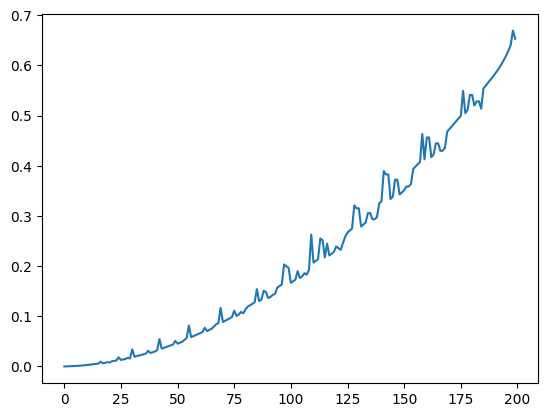

In [31]:
plt.plot(np.linalg.eigvals(-t_matrix))
# format_plot(use_loglog=True)
plt.show()

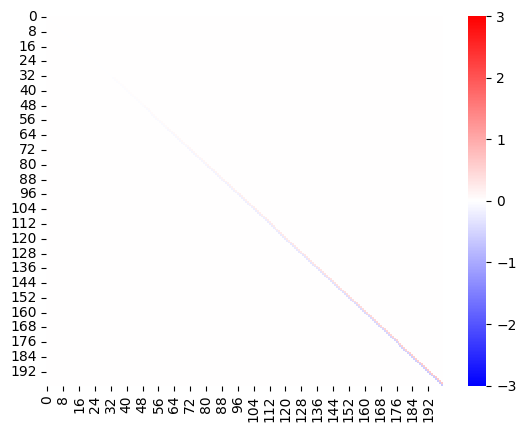

In [32]:
sns.heatmap(t_matrix,vmin=-3,vmax=3,cmap='bwr')
plt.show()

In [33]:
# dp_values =  #dpdt
# dp_values*=DT

In [34]:
# Wp,Wm

In [35]:
#TODO: dev one step method from the recurrance relation from the master equation
#HINT: i can copy stuff from the quasistatic solution 
# if i don't want to transcribe my easily accessible notes from this afternoon.
#TODO: compute transition from lo to hi
#TODO: compute transition from hi to lo
#TODO: format this as a matrix
#TODO: multiply by the transition matrix until  

In [36]:
#TODO: compute thresholds lo and hi given N

In [37]:
# pthresh_lo=?

In [38]:
# pthresh_hi=?

In [39]:
# dim=max_num_particles_init_over_2
# t_matrix=np.zeros((dim,dim))
# l_matrix=np.zeros((dim,dim))
# i_matrix=np.eye(dim)
# for i in range(dim):
#     im=i-1
#     #im=i+1
#     for j in range(dim):
#         if im==j:
#             l_matrix[i,j]=1
# # i_matrix      
# l_matrix.T

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
# #TODO: derive the rate of growth/decay at each n value
# N=6
# random_state=42
# assert N%2==0
# np.random.seed(random_state)
# p = np.random.rand()
# if p<pthresh_lo:
#     print(f"oh oh! lo fo sho!")
# if p<pthresh_hi:
#     print(f"he hi! wanna come by!?")

In [41]:

# # p_deque = deque(np.array(list(range(max_num_particles_init_over_2))))
# # p_deque = deque(np.array(list(range(max_num_particles_init_over_2))))
# n_deque = deque(np.arange(1,N+1))
# p_deque = deque([0.*x for x in n_deque])
# n_deque.
# d = deque([1,2,3,4])

# # # print d
# # for x in d:
# #     print x
# # # print d.pop(), d

# fit powerlaws to birth/death rates

In [42]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

In [43]:
birth_rate_dir_fk = f'{nb_dir}//data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}//data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [44]:
# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [45]:
xv = np.arange(0.02, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

#compute the intersection point for both of the full models
index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
qstar_fk = xv[index_fk]
wstar_fk = yv_birth_fk[index_fk]
# index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
qstar_lr = xv[index_lr]
wstar_lr = yv_birth_lr[index_lr]
qstar_lr

0.16999999999999996

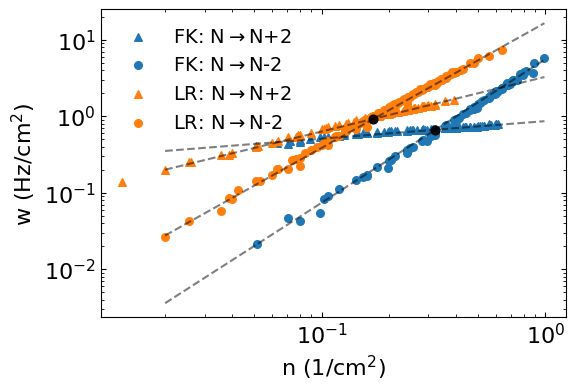

In [46]:
fig,ax=plt.subplots(figsize=(6,4))
fontsize=16
alpha=0.9
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)
#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)
#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)
# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
plt.legend(fontsize=14,frameon=False,loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

# DONE: test the apparent error of Eqn. 10 using directly integrating the master equations as the gold standard

Eqn. 10 reads:
$$
\tau(N) = \sum_{k=1}^{N/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)},
$$
Mean termination time is calculated according to
$$
\mathbb{E}[\tau] = \sum_{N=0}^\infty \tau(N) P(N).
$$

In [54]:
# DONE: completed ^this in ibid.

Nbar=7.624837359362673


# analytical check: test whether tau(N_0) increases exponentially with A

We have an expressions for $\tau(N)$ in terms of the action variable, $\phi$:
 
$$
\tau(N) = \sum_{k=1}^{N/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)},
$$
and 
$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i)}{W_{+2}(2i)}.
$$

Given the mean termination time conditioned on $N$ particles existing, we estimate the mean termination time according to:
$$
\mathbb{E}[\tau] = \sum_{N=0}^\infty \tau(N) P(N)
$$
Where $P(N)$ is the quasistatic distribution.


In [ ]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

In [ ]:
print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

In [ ]:
# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
N0_values = np.arange(2,12,2)
# N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau.head()

In [ ]:
#basic scatter plot of the data
figsize=(5,4)
cmap='viridis'
vmin=0
vmax=np.max(N0_values)
fontsize=14
fig,ax=plt.subplots(figsize=figsize)
#plot data
df_tau.plot.scatter(x='A',y='tau',c='N0',s=10,alpha=0.7,
                    cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,colorbar=False)
    
#add colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$N_0$', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

# format_plot
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
plt.show()

## scratch work

In [ ]:
# TODO(later): search for universal relations involving tau(N_0) and A

In [ ]:
groups = df_tau.groupby(by='N0')

In [ ]:

#
#define xy columns
df_tau['x'] = df_tau['A']
df_tau['y'] = df_tau['tau']
#TODO: extract xy values
for N0,g in df_tau.groupby(by='N0'):
    pass
x_values = g['A'].values #A
# x_values = N0/g['A'].values #q


# plot $\tau(N_0)$ versus $A$ for both the full models

In [ ]:
N0_values = np.arange(2,12,2)
# N0_values = np.arange(2,40,2)
N0_values = np.array([2,20])
N0_values

In [ ]:
np.floor(20/2),np.floor(2/2)

In [ ]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
# N0_values = np.arange(2,12,2)
# # N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau_fk = df_tau.copy()

In [ ]:
#DONE: get token inputs prepared
# dict_fit_death_lr = dict(wjr['lr_pbc'])
# dict_fit_death_fk = dict(wjr['fk_pbc'])
# Mp = dict_fit_birth_fk['M']
# nup = dict_fit_birth_fk['m']
# Mm = dict_fit_death_fk['M']
# num = dict_fit_death_fk['m']
# model_name='Fenton-Karma'

Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'

print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
# N0_values = np.arange(2,12,2)
# # N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau_lr = df_tau.copy()

In [ ]:
#basic scatter plot of the data at N_0 fixed
N0 = 2
N0 = 20
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
ylim = (0.0005007487135910895, 5.156057164412211e+44)
# ylim=0.0005,100
# xlim=1,20

# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
#basic scatter plot of the data at N_0 fixed
# N0 = 2
N0 = 20
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [ ]:
#DONE: zoom into small A and verify that N0=2 is not erroneously N0=20
#DONE: add exponential fits as dotted lines to ibid
#DONT: figure how the characteristic Ac varies with the parameters
#HINT: start with my hypothesis, A0, as Ac.
#DONE: get token inputs prepared
# dict_fit_death_lr = dict(wjr['lr_pbc'])
# dict_fit_death_fk = dict(wjr['fk_pbc'])

In [ ]:
# xfactor=4.
# xfactor=0.7 #<<worse.
# xfactor=0.66 #<<worse
# xfactor=0.6 #<<worse?
# xfactor=0.55 #<<worse?
# xfactor=1 #<<worse?
# xfactor = (1.46025/2.21033)**2
# xfactor=0.45 #<<worse.
xfactor=0.5
# xfactor=2/np.pi
# xfactor=3/np.pi/2
# xfactor=4/np.pi/3
# xfactor=5/np.pi/4
# xfactor=0.4 #<<worse.
print(f"{xfactor=}")

Claim:`xfactor`=0.5, for

$$
A_0 = \frac{1}{2}\Big(x\frac{M_-}{M_+}\Big)^{1/(\nu_--\nu_+)}
$$

where $x=$4.19033 +/- 0.34682 for the Luo-Rudy model <br> and $x=$4.57527 +/- 0.38506 for the Fenton-Karma model.

__with initial formula__:<br>
For Fenton-Karma:
Inputs:
Mp=0.8642103569057054; nup=0.22959399086621063
Mm=5.572315674840435; num=1.8772341309722325
	--> qstar=0.3200; wstar=0.6653
x=0.46568 +/- 0.03596
let y=x**(1/(num-nup)). then,
y=0.62885 +/- 0.13289

For Luo-Rudy:
Inputs:
Mp=3.2770725040489235; nup=0.7147550082416185
Mm=16.73559858353835; num=1.6375562704001745
	--> qstar=0.1700; wstar=0.9235
x=1.16347 +/- 0.08143
let y=x**(1/(num-nup)). then,
y=1.17830 +/- 0.06601

__with num-nup --> nup-num__:<br>
For Fenton-Karma:
Inputs:
Mp=0.8642103569057054; nup=1.8772341309722325
Mm=5.572315674840435; num=0.22959399086621063
	--> qstar=0.9900; wstar=0.8481
x=0.05165 +/- 0.00370
let y=x**(1/(num-nup)). then,
y=6.04040 +/- 29.90383

For Luo-Rudy:
Inputs:
Mp=3.2770725040489235; nup=1.6375562704001745
Mm=16.73559858353835; num=0.7147550082416185
	--> qstar=0.9900; wstar=3.2236
x=0.03296 +/- 0.00216
let y=x**(1/(num-nup)). then,
y=40.36936 +/- 775.35777

	  *** at N0=2: ***
*** A0: 3.8999 +/- 0.0553 cm^2 (FK) ***
*** A0: 13.8252 +/- 1.2442 cm^2 (LR) ***
      *** at N0=20: ***
*** A0: 3.8980 +/- 0.0509 cm^2 (FK) ***
*** A0: 13.7938 +/- 1.0491 cm^2 (LR) ***

In [ ]:
#measure A0 from exponential fit to tau(A)
# N0=2
N0=20
Amin=200
boo = df_tau_fk['N0']==N0
# boo&= df_tau_fk['A']>=Amin
xv,yv=df_tau_fk[boo][['A','tau']].values.T
print(f"Measurements of A0 = 1/m by OLS:")
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nFenton-Karma:")
# print_fit_exponential(xv,yv)
A0fk=float(1./m)
Delta_A0fk=float(Delta_m*float(1./m)/(m**2))
yvhatfk=yvhat.copy()
yvfk=yv.copy()
xvfk=xv.copy()
print(f"A0: {A0fk:.4f} +/- {Delta_A0fk}  ***********************")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.6f} +/- {Delta_tau0=:.6f}  ***********************")
boo = df_tau_lr['N0']==N0
boo&= df_tau_lr['A']>=Amin
xv,yv=df_tau_lr[boo][['A','tau']].values.T
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nLuo-Rudy:")
print_fit_exponential(xv,yv)
A0lr=float(1./m)
Delta_A0lr=float(Delta_m*float(1./m)/(m**2))
yvhatlr=yvhat.copy()
yvlr=yv.copy()
xvlr=xv.copy()
print(f"A0: {A0lr:.4f} +/- {Delta_A0lr} ***********************")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.4f} +/- {Delta_tau0=:.4f} ***********************")
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'
# nu=nup;nup=num;num=nu
A0=A0fk
Delta_A0=Delta_A0fk
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} ({xfactor=})")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'
# nu=nup;nup=num;num=nu
A0=A0lr
Delta_A0=Delta_A0lr
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} ")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")
print(f"\nQ: Do x agree?")
print(f"here: {xfactor=}")

In [ ]:
#basic scatter plot of the data at N_0 given
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
#plot the fits as dotted lines
# xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvfk=xv.copy()
yvhatfk=np.exp(xv*m+B)
ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)
xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>200],yv[xv>200])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvlr=xv.copy()
# yvhatlr=np.exp(xv*m-B)
yvhatlr=np.exp(B)*np.exp(xv*m)
ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [ ]:
# #N0=2:
# xvfk2,yvhatfk2,xvlr2,yvhatlr2 = xvfk,yvhatfk,xvlr,yvhatlr
# df_tau_fk2=df_tau_fk.copy()
# df_tau_lr2=df_tau_lr.copy()
# # #N0=20:
xvfk20,yvhatfk20,xvlr20,yvhatlr20 = xvfk,yvhatfk,xvlr,yvhatlr
df_tau_fk20=df_tau_fk.copy()
df_tau_lr20=df_tau_lr.copy()

print(f"\t  *** at {N0=}: ***")
print(f"*** A0: {A0fk:.4f} +/- {Delta_A0fk:.4f} cm^2 (FK) ***")
print(f"*** A0: {A0lr:.4f} +/- {Delta_A0lr:.4f} cm^2 (LR) ***")

In [ ]:
#measure A0 from exponential fit to tau(A)
N0=2
# N0=20
Amin=200
boo = df_tau_fk['N0']==N0
boo&= df_tau_fk['A']>=Amin
xv,yv=df_tau_fk[boo][['A','tau']].values.T
print(f"Measurements of A0 = 1/m by OLS:")
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nFenton-Karma:")
# print_fit_exponential(xv,yv)
A0fk=float(1./m)
Delta_A0fk=float(Delta_m*float(1./m)/(m**2))
yvhatfk=yvhat.copy()
yvfk=yv.copy()
xvfk=xv.copy()
print(f"A0: {A0fk:.4f} +/- {Delta_A0fk}  ***********************")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.6f} +/- {Delta_tau0=:.6f}  ***********************")
boo = df_tau_lr['N0']==N0
boo&= df_tau_lr['A']>=Amin
xv,yv=df_tau_lr[boo][['A','tau']].values.T
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nLuo-Rudy:")
# print_fit_exponential(xv,yv)
A0lr=float(1./m)
Delta_A0lr=float(Delta_m*float(1./m)/(m**2))
yvhatlr=yvhat.copy()
yvlr=yv.copy()
xvlr=xv.copy()
print(f"A0: {A0lr:.4f} +/- {Delta_A0lr} ***********************")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.4f} +/- {Delta_tau0=:.4f} ***********************")
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'
# nu=nup;nup=num;num=nu
A0=A0fk
Delta_A0=Delta_A0fk
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} ({xfactor=})")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'
# nu=nup;nup=num;num=nu
A0=A0lr
Delta_A0=Delta_A0lr
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} ")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")
print(f"\nQ: Do x agree?")
print(f"here: {xfactor=}")

In [ ]:
#basic scatter plot of the data at N_0 given
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
#plot the fits as dotted lines
# xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvfk=xv.copy()
yvhatfk=np.exp(xv*m+B)
ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)
xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvlr=xv.copy()
# yvhatlr=np.exp(xv*m-B)
yvhatlr=np.exp(B)*np.exp(xv*m)
ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [ ]:
# #N0=2:
xvfk2,yvhatfk2,xvlr2,yvhatlr2 = xvfk,yvhatfk,xvlr,yvhatlr
df_tau_fk2=df_tau_fk.copy()
df_tau_lr2=df_tau_lr.copy()
# # #N0=20:
# xvfk20,yvhatfk20,xvlr20,yvhatlr20 = xvfk,yvhatfk,xvlr,yvhatlr
# df_tau_fk20=df_tau_fk.copy()
# df_tau_lr20=df_tau_lr.copy()

print(f"\t  *** at {N0=}: ***")
print(f"*** A0: {A0fk:.4f} +/- {Delta_A0fk:.4f} cm^2 (FK) ***")
print(f"*** A0: {A0lr:.4f} +/- {Delta_A0lr:.4f} cm^2 (LR) ***")

In [ ]:
viewer_pkl_dir=f"{nb_dir}/data/figure_data_tauratio_20_to_2_vs_A.pkl"

In [ ]:
saving=True
# saving=False
if saving:
    #DONE: put in dict. save to .pkl
    data=dict(
        df_tau_fk2=df_tau_fk2,
        df_tau_fk20=df_tau_fk20,
        df_tau_lr2=df_tau_lr2,
        df_tau_lr20=df_tau_lr20,
        xvfk2=xvfk2,yvhatfk2=yvhatfk2,xvlr2=xvlr2,yvhatlr2=yvhatlr2,
        xvfk20=xvfk20,yvhatfk20=yvhatfk20,xvlr20=xvlr20,yvhatlr20=yvhatlr20,
    )
    save_to_pickle(viewer_pkl_dir, data)
    print(f"{viewer_pkl_dir=}")

# plot ratio pf tau( N0=20 ) to tau( N0=2 )

In [ ]:
# import pandas as pd
# pd.__version__

In [ ]:
# from lib import *

In [ ]:
# # !pip install pandas==1.4.1
# import pickle
# def load_from_pickle(input_fn):
#     with open(input_fn,'rb') as f: dict_pkl = pickle.load(f)
#     return dict_pkl
# viewer_pkl_dir=f"{nb_dir}/data/figure_data_tauratio_20_to_2_vs_A.pkl"
# data = load_from_pickle(viewer_pkl_dir)
# df_tau_fk = data['df_tau_fk2']
# df_tau_lr = data['df_tau_lr2']
# print ( f"{df_tau_fk.describe()=}")
# print ( f"\n{df_tau_lr.describe()=}")
# data.keys()

In [ ]:
viewer_pkl_dir=f"{nb_dir}/data/figure_data_tauratio_20_to_2_vs_A.pkl"
data = load_from_pickle(viewer_pkl_dir)
df_tau_fk2 = data['df_tau_fk2']
df_tau_lr2 = data['df_tau_lr2']
df_tau_fk20 = data['df_tau_fk20']
df_tau_lr20 = data['df_tau_lr20']

In [ ]:
#compute the ratio of their values in a given dataframe
df_tau_fk2['tauratio'] = df_tau_fk20['tau']/df_tau_fk2['tau']
df_tau_lr2['tauratio'] = df_tau_lr20['tau']/df_tau_lr2['tau']

In [ ]:
#N0 is already in df_tau, you big dummy!  At least now i can easily put a dotted line around their exponential fit's ratio
data.keys()

In [ ]:
globals().update(data)
# for x in ["xvfk2","yvhatfk2","xvlr2","yvhatlr2","xvfk20","yvhatfk20","xvlr20","yvhatlr20"]:
#     globals().update(data)[x])
# data['yvhatfk20'].shape,data['yvhatfk2'].shape
# ,xvlr20

In [ ]:
# plt.scatter(Afk,trfk,c='C0',alpha=1.,s=10,label='Fenton-Karma')
# plt.scatter(Alr,trlr,c='C1',alpha=1.,s=10,label='Luo-Rudy')
# ax.plot(xvfk2,yvhatfk20/yvhatfk2,'k--',alpha=0.7,lw=2)
# ax.plot(xvlr2,yvhatlr20/yvhatlr2,'k--',alpha=0.7,lw=2)

In [ ]:
#TODO: compute their correct ratio
Afk = df_tau_fk20.loc[df_tau_fk20['N0']==2,'A'].values
t2fk = df_tau_fk20.loc[df_tau_fk20['N0']==2,'tau'].values
t20fk = df_tau_fk20.loc[df_tau_fk20['N0']==20,'tau'].values
trfk=t20fk/t2fk


Alr = df_tau_lr20.loc[df_tau_lr20['N0']==2,'A'].values
t2lr = df_tau_lr20.loc[df_tau_lr20['N0']==2,'tau'].values
t20lr = df_tau_lr20.loc[df_tau_lr20['N0']==20,'tau'].values
trlr=t20lr/t2lr



In [ ]:
#TODO: dev plotter for ^this data
#HINT: plot ratio pf tau( N0=20 ) to tau( N0=2 )
xvfk20.shape,xvfk2.shape,yvhatfk20[xvfk20>=25].shape,yvhatfk2[[xvfk2>=25]].shape

In [ ]:
#basic scatter plot of the data at N_0 given
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
# #plot data
# # df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# # df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
# df_tau_fk2[df_tau_fk2['N0']==N0].plot(x='A',y='tauratio',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
# df_tau_lr2[df_tau_lr2['N0']==N0].plot(x='A',y='tauratio',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)


# #plot the fits as dotted lines
# # xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
# xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
# xvfk=xv.copy()
# yvhatfk=np.exp(xv*m+B)
# # yvhatfk=-B*np.exp(xv*m)
# # yvhatfk=1e-3*np.exp(xv*m)
# # yvhatfk=np.exp(xvfk/A0fk-B)
# ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)
# xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
# xvlr=xv.copy()
# # yvhatlr=np.exp(xv*m-B)
# yvhatlr=np.exp(B)*np.exp(xv*m)
# ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)
    
# ax.plot(xvfk20,yvhatfk20[xvfk20>=25]/yvhatfk2[[xvfk2>=25]],'k--',alpha=0.7,lw=2)
# ax.plot(xvlr20,yvhatlr20[xvlr20>=25]/yvhatlr2[[xvlr2>=25]],'k--',alpha=0.7,lw=2)
ax.plot(xvfk2,yvhatfk20/yvhatfk2,'k--',alpha=0.7,lw=2)
ax.plot(xvlr2,yvhatlr20/yvhatlr2,'k--',alpha=0.7,lw=2)
ax.plot(Afk,trfk,c='C0',alpha=.7,lw=2,label='Fenton-Karma')
ax.plot(Alr,trlr,c='C1',alpha=.7,lw=2,label='Luo-Rudy')

# ax.set_ylim([1,2.5])
ax.set_ylim([0,3])
# ax.set_ylim([1,3])
#format plot, as before
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0=20)\,/\,\tau(N_0=2)$',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0=20)\,/\,\tau(N_0=2)$',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
# ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [ ]:
#HERETIM: 
#DONE: esimate xvfk,yvhatfk,xvlr,yvhatlr for N0=2
#DONE: esimate xvfk,yvhatfk,xvlr,yvhatlr for N0=20

#DONE: compute their correct ratio
#DONE: plot their ratio versus A
#DONE: update the supplemental figure in .odg
#TODO: update git
#TODO: update the SM with ^that

In [ ]:
# #basic scatter plot of the data at N_0 given
# # xlim
# figsize=(4,4)
# fontsize=16
# markersize=10
# alpha=1.0
# # ylim = (0.0005007487135910895, 5.156057164412211e+44)
# # alpha=0.7
# fig,ax=plt.subplots(figsize=figsize)
# # #plot data
# # # df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# # # df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
# # df_tau_fk2[df_tau_fk2['N0']==N0].plot(x='A',y='tauratio',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
# # df_tau_lr2[df_tau_lr2['N0']==N0].plot(x='A',y='tauratio',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)


# # #plot the fits as dotted lines
# # # xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
# # xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
# # B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
# # xvfk=xv.copy()
# # yvhatfk=np.exp(xv*m+B)
# # # yvhatfk=-B*np.exp(xv*m)
# # # yvhatfk=1e-3*np.exp(xv*m)
# # # yvhatfk=np.exp(xvfk/A0fk-B)
# # ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)
# # xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
# # B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
# # xvlr=xv.copy()
# # # yvhatlr=np.exp(xv*m-B)
# # yvhatlr=np.exp(B)*np.exp(xv*m)
# # ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)
    
# ax.plot(xvfk2,(yvhatfk20-yvhatfk2)/yvhatfk2,'k--',alpha=0.7,lw=2)
# ax.plot(xvlr2,(yvhatlr20-yvhatlr2)/yvhatlr2,'k--',alpha=0.7,lw=2)


# ax.plot(Afk,trfk-1,c='C0',alpha=.7,lw=2,label='Fenton-Karma')
# ax.plot(Alr,trlr-1,c='C1',alpha=.7,lw=2,label='Luo-Rudy')

# # ax.set_ylim([1,2.5])
# ax.set_ylim([0,2])
# #format plot, as before
    
# # format_plot
# # format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
# # format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0=20)\,/\,\tau(N_0=2)$',fontsize=fontsize)
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$(\tau(N_0=20) - \tau(N_0=2))\,/\,\tau(N_0=2)$',fontsize=fontsize)
# # ax.set_title(model_name,fontsize=fontsize)
# # ax.set_yscale('log')
# # plt.tight_layout()
# ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# # ax.set_ylim(ylim)
# # ax.set_ylim(xlim)
# plt.show()

# converting save file to ascii as the requested table

In [ ]:
#compute their correct ratio
Afk = df_tau_fk20.loc[df_tau_fk20['N0']==2,'A'].values
t2fk = df_tau_fk20.loc[df_tau_fk20['N0']==2,'tau'].values
t20fk = df_tau_fk20.loc[df_tau_fk20['N0']==20,'tau'].values
trfk=t20fk/t2fk

Alr = df_tau_lr20.loc[df_tau_lr20['N0']==2,'A'].values
t2lr = df_tau_lr20.loc[df_tau_lr20['N0']==2,'tau'].values
t20lr = df_tau_lr20.loc[df_tau_lr20['N0']==20,'tau'].values
trlr=t20lr/t2lr

In [ ]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

In [ ]:
print_dict(dict_fit_birth_fk)
print(f"")
print_dict(dict_fit_birth_lr)

In [ ]:
#Q: what does WJ want for 'full MTE'
#NOTE: ^this means averaging over P_qs, which I didn't do before, but I can do now without much difficulty...

In [ ]:
# plot $\tau$ versus $A$ for both the full models
# fork from?: plot $\tau(N_0)$ versus $A$ for both the full models
# eval_tau_expression

In [ ]:
# eval_tau

In [ ]:
num_iter=20 # runtime 3 seconds
num_iter=20 # runtime 30 seconds integrating each a second time to the mean num. particles
num_iter=20 # runtime 4 minutes integrating each a second time to the mean+30 particles
# num_iter=21 # runtime 3.5 seconds
# num_iter=40 # runtime 40 seconds
# num_iter=100 # too long runtime >14
printing=True
A_values = Afk.copy()
nvals=A_values.shape[0]
tau_values = np.zeros(nvals)
eval_tau= get_eval_tau(eval_tau_expression)
for i,A in enumerate(A_values):
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
    Nbar = np.dot(n_qs,prob_qs)
    #num_iter2 = int(np.ceil(Nbar))
    #num_iter2 = int(np.ceil(Nbar))+3
    num_iter2 = int(np.ceil(Nbar))+30 #4 min.
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter2,freq_prev=1.) #correct qs
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False)#,**kwargs)  # <<< primary source of runtime
    #tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    tau_values[i]=tau
    #print progress bar
    if printing:
        printProgressBar(i+1, nvals, prefix = 'Progress:', suffix = 'Complete', length = 50)        
    

In [ ]:
#record values in namespace
A_values_fk,tau_values_fk = A_values.copy(),tau_values.copy()

In [ ]:
#repeat for LR model
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'
num_iter=20 # runtime 4 minutes integrating each a second time to the mean+30 particles
printing=True
A_values = Afk.copy()
nvals=A_values.shape[0]
tau_values = np.zeros(nvals)
eval_tau= get_eval_tau(eval_tau_expression)
for i,A in enumerate(A_values):
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    phi = get_phi(comp_Wm,comp_Wp)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
    Nbar = np.dot(n_qs,prob_qs)
    #num_iter2 = int(np.ceil(Nbar))
    #num_iter2 = int(np.ceil(Nbar))+3
    num_iter2 = int(np.ceil(Nbar))+30 #4 min.
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter2,freq_prev=1.) #correct qs
    tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False)#,**kwargs)  # <<< primary source of runtime
    #tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    tau_values[i]=tau
    #print progress bar
    if printing:
        printProgressBar(i+1, nvals, prefix = 'Progress:', suffix = 'Complete', length = 50)        

In [ ]:
#record values in namespace
A_values_lr,tau_values_lr = A_values.copy(),tau_values.copy()

In [ ]:
plt.plot(A_values_fk,tau_values_fk)
plt.plot(A_values_lr,tau_values_lr,c='C1')
plt.yscale('log')
format_plot(xlabel=r'$A$ (cm$^2$)',ylabel=r'$\tau$   (s)')
plt.show()

In [ ]:
#TODO: format ^these to df
df1=pd.DataFrame({
    'model':'FK',#'LR',
    'area': A_values_fk, #Afk,#Alr,
    'full MTT': tau_values_fk, #tau_values_lr
    'MTT(N=2)': t2fk,  #t2lr,
    'MTT(N=20)': t20fk, #t20lr,
})
df2=pd.DataFrame({
    'model':'LR',
    'area':Alr,
    'full MTT': tau_values_lr,
    'MTT(N=2)': t2lr,
    'MTT(N=20)': t20lr,
})
df_tau_vs_A=pd.concat([df1,df2])
# area, full MTE, MTE(N=2), MTE(N=20).
# pandas.DataFrame.to_csv
# encoding : string, optional
# A string representing the encoding to use in the output file, defaults to ‘ascii’ on Python 2 and ‘utf-8’ on Python 3
df_tau_vs_A

In [ ]:
#save df as .csv with encoding='ascii'
save_tau_vs_A_dir = f"{nb_dir}/data/figure_data_tau_vs_A_c.csv"
# save_tau_vs_A_dir = f"{nb_dir}/data/figure_data_tau_vs_A.csv"
df_tau_vs_A.to_csv(save_tau_vs_A_dir,encoding='ascii',index=False)
print(f"{save_tau_vs_A_dir=}")

In [ ]:
beep(3)

In [ ]:
# Q: does tau agree any better with Table 2?
df_tau_vs_A[df_tau_vs_A['area']==25]

In [ ]:
# # xfactor=4.
# # xfactor=0.7 #<<worse.
# # xfactor=0.66 #<<worse
# # xfactor=0.6 #<<worse?
# # xfactor=0.55 #<<worse?
# # xfactor=1 #<<worse?
# # xfactor = (1.46025/2.21033)**2
# # xfactor=0.45 #<<worse.
# xfactor=0.5
# # xfactor=2/np.pi
# # xfactor=3/np.pi/2
# # xfactor=4/np.pi/3
# # xfactor=5/np.pi/4

In [ ]:

# Mp = dict_fit_birth_fk['M']
# nup = dict_fit_birth_fk['m']
# Mm = dict_fit_death_fk['M']
# num = dict_fit_death_fk['m']
# model_name='Fenton-Karma'
# # nu=nup;nup=num;num=nu

# A0=A0fk
# Delta_A0=Delta_A0fk
# # x=Mp/Mm * (A0/2.)**(num-nup)
# # Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
# x=Mp/Mm * (A0/xfactor)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
# print(f"\nFor {model_name}:")
# print(f"Inputs:")
# print(f"- {Mp=}; {nup=}")
# print(f"- {Mm=}; {num=}")
# _xv = np.arange(0.02, 1,0.01)
# qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
# print(f"Outputs:")
# print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
# print(f"*** {x=:.5f} +/- {Delta_x:.5f} ({xfactor=})")
# # print(f"let y=x**(1/(num-nup)). then,")
# y=x**(1/(num-nup))
# Delta_y=Delta_x**(1/(num-nup))
# print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")


# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'
# # nu=nup;nup=num;num=nu

# A0=A0lr
# Delta_A0=Delta_A0lr
# # x=Mp/Mm * (A0/2.)**(num-nup)
# # Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
# x=Mp/Mm * (A0/xfactor)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
# print(f"\nFor {model_name}:")
# print(f"Inputs:")
# print(f"- {Mp=}; {nup=}")
# print(f"- {Mm=}; {num=}")
# _xv = np.arange(0.02, 1,0.01)
# qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
# print(f"Outputs:")
# print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
# print(f"*** {x=:.5f} +/- {Delta_x:.5f} ")
# # print(f"let y=x**(1/(num-nup)). then,")
# y=x**(1/(num-nup))
# Delta_y=Delta_x**(1/(num-nup))
# print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")

# print(f"\nQ: Do x agree?")
# print(f"here: {xfactor=}")

In [ ]:
#print the exponential fits. 

#fit exponentials to FK
print(f"OLS Exponential Fits:")
xv = A_values_fk
yv = tau_values_fk
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nFenton-Karma:")
# print_fit_exponential(xv,yv)
A0fk=float(1./m)
Delta_A0fk=float(Delta_m*float(1./m)/(m**2))
yvhatfk=yvhat.copy()
yvfk=yv.copy()
xvfk=xv.copy()
print(f"- A0:\t{A0fk:.4f} +/- {Delta_A0fk:.4f} (cm^2)")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"- tau0:\t{tau0:.4f} +/- {Delta_tau0:.4f} (seconds)")
tau0fk=float(tau0)
Delta_tau0fk=float(Delta_tau0)

print(f"\nLuo-Rudy:")
xv = A_values_lr
yv = tau_values_lr
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
# print_fit_exponential(xv,yv)
A0lr=float(1./m)
Delta_A0lr=float(Delta_m*float(1./m)/(m**2))
yvhatlr=yvhat.copy()
yvlr=yv.copy()
xvlr=xv.copy()
print(f"- A0:\t{A0lr:.4f} +/- {Delta_A0lr:.4f} (cm^2)")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"- tau0:\t{tau0:.4f} +/- {Delta_tau0:.4f} (seconds)")
tau0lr=float(tau0)
Delta_tau0lr=float(Delta_tau0)

before change: 

OLS Exponential Fits:

Fenton-Karma:
- A0:	13.7367 +/- 0.8758 (cm^2)
- tau0:	0.0593 +/- 0.0048 (seconds)

Luo-Rudy:
- A0:	13.7367 +/- 0.8758 (cm^2)
- tau0:	0.0593 +/- 0.0048 (seconds)

In [ ]:
#TODO: plot traces with exponential fits overlaid, like before
#basic scatter plot of the data at N_0 given
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
ycol='tau'
ycol='full MTT'
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_vs_A[df_tau_vs_A['model']=='FK'].plot(x='area',y=ycol,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_vs_A[df_tau_vs_A['model']=='LR'].plot(x='area',y=ycol,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)

#plot the fits as dotted lines
# xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
# xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
xv,yv=df_tau_vs_A[df_tau_vs_A['model']=='FK'][['area',ycol]].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvfk=xv.copy()
yvhatfk=np.exp(xv*m+B)
# yvhatfk=-B*np.exp(xv*m)
# yvhatfk=1e-3*np.exp(xv*m)
# yvhatfk=np.exp(xvfk/A0fk-B)
ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)

# xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
xv,yv=df_tau_vs_A[df_tau_vs_A['model']=='LR'][['area',ycol]].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv[xv>Amin],yv[xv>Amin])
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvlr=xv.copy()
# yvhatlr=np.exp(xv*m-B)
yvhatlr=np.exp(B)*np.exp(xv*m)
ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)

# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$  (seconds)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [ ]:
#DONE: add exponential fits to .odg
#TODO: copy the input powerlaw fits to .odg
#heretim
#TODO: update .odg and share with WJ, attaching the aforementioned .csv

In [ ]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'
print(f"{model_name}:")
print(f"  {Mp=}; {nup=}")
print(f"  {Mm=}; {num=}")
xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"    --> mean values: {qstar=:.4f}; {wstar=:.4f}")


Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'
print(f"{model_name}:")
print(f"  {Mp=}; {nup=}")
print(f"  {Mm=}; {num=}")
xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"    --> mean values: {qstar=:.4f}; {wstar=:.4f}")



In [ ]:
# #DONE: estimate the exponential fit using fit_exponential
# xv=A_values.copy(); yv=tau_values.copy()
# B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
# yvhat=np.exp(B)*np.exp(xv*m)
# plt.plot(xv,yvhat,'k:',alpha=0.7,lw=2)
# plt.yscale('log')

In [ ]:
beep(3)
#TODO: plot ^this trace for LR overlaid with FK
#TODO: save ^these to .csv with the other data
#TODO: share with wjr

In [ ]:
#heretim
plt.plot(A_values,tau_values)
plt.yscale('log')
format_plot(xlabel=r'$A$ (cm$^2$)',ylabel=r'$\tau$   (s)')
plt.show()

In [ ]:
A=25
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
phi = get_phi(comp_Wm,comp_Wp)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
Nbar = np.dot(n_qs,prob_qs)

In [ ]:
#Q: does changing the divide by net probability change tau?
# A: no.
#Q: does changing max cutoff change tau?
# A: no.
#Q: does reversing the change to inner_sum *= phi(2*k) change tau?
# A: yes. tau=25.856213587248263, (Nbar=7.624837359362673)
#heretim
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
print(f"{tau=}, ({Nbar=})")

In [ ]:
#after change to inner_sum *= phi(2*k) change tau
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
print(f"{tau=}, ({Nbar=})")

In [ ]:
#after change to kk from k
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
print(f"{tau=}, ({Nbar=})")

In [ ]:
#after change to j from jj
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
print(f"{tau=}, ({Nbar=:.2f})")

In [50]:
#...
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
print(f"{tau=}, ({Nbar=:.2f})")

NameError: name 'phi' is not defined

In [ ]:
# phi(2)-0.1004090260 = 7.64461033277708e-05 >>> the error between our phi(2) values
for j in range(2,20):
    print(j)

In [51]:
# FK:
# - Full MTE: 27.8±6.5 s
# - MTE (before change): 25.9 s
# - MTE (after change): 14.73 s 
27.8/14.73

1.8873048200950442

In [52]:
# LR:
# - Full MTE: 0.74±0.06 s
# - MTE (before change): 0.51 s
# - MTE (after change): 0.46 s 
0.74/0.46

1.6086956521739129

In [53]:
phi(2)

NameError: name 'phi' is not defined